Load libraries

In [10]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from scipy.ndimage import gaussian_filter, map_coordinates 
from typing import Any
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix



Load the csv with the names of the iamges and their fonts

In [2]:
df = pd.read_csv('pages.csv')
df_1 = pd.DataFrame(df).rename(columns={'Unnamed: 1': 'fonts'})
df_2 = df_1['pages'].str.replace('^img\\\\', '', regex=True)
df_rete = df_1[['pages', 'fonts']].copy()
df_rete['pages'] = df_rete['pages'].str.replace('^img\\\\', '', regex=True)

Create the folders for the tranformed images

In [3]:
current_path = os.getcwd()
# Define the folder path where the images are stored
image_folder = f"{current_path}\\TheLibrarianFromAlexandria\\img"
output_folder = f"{current_path}\\TheLibrarianFromAlexandria\\immagini_formattate"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
output_folder_2 = f"{current_path}\\TheLibrarianFromAlexandria\\immagini_reteneurale"
if not os.path.exists(output_folder_2):
    os.makedirs(output_folder_2)

Convert the input image to grayscale, apply a binary threshold to create a black-and-white image,
Then use a median filter to reduce noise, and finally save the processed image to the specified output path.

In [ ]:

def preprocess_and_save_final_image(img: Any, img_name: str):
    gray = img.convert("L")  # 'L' = grayscale
    threshold = 128  
    binary = gray.point(lambda p: 255 if p > threshold else 0)
    denoised = binary.filter(ImageFilter.MedianFilter(size=3))  
    denoised_image_path = os.path.join(output_folder, f"{img_name}")
    denoised.save(denoised_image_path)  
    print(f"Immagine denoised salvata come: {denoised_image_path}")

Apply a sequence of data augmentation techniques—including random affine transformations, flips, and color jittering —
Then add Gaussian noise and apply elastic deformation to the image, finally saving the fully transformed image to disk.


In [ ]:

def data_augmentation(image):
    augmentation = transforms.Compose([          
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
        transforms.RandomHorizontalFlip(p=0.5),             
        transforms.RandomVerticalFlip(p=0.3),                
        transforms.ColorJitter(brightness=0.3, contrast=0.3), 
    ])
    augmented_image = augmentation(image)  
    return augmented_image  

def add_noise(image):
    arr = np.array(image).astype(np.float32)
    noise = np.random.normal(0, 25, arr.shape)
    noisy = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy)

def elastic_transform(image, alpha=1000, sigma=40):
    arr = np.array(image)
    shape = arr.shape
    dx = gaussian_filter((np.random.rand(*shape)*2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.rand(*shape)*2 - 1), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    distorted = map_coordinates(arr, indices, order=1, mode='reflect').reshape(shape)
    return Image.fromarray(distorted.astype(np.uint8))

def apply_all_transformations(image, img_name):
    augmented_image = data_augmentation(image)
    noisy_image = add_noise(augmented_image)
    final_image = elastic_transform(noisy_image)
    final_image_path = os.path.join(output_folder_2, f"{img_name}")
    final_image.save(final_image_path)  
    print(f"Immagine finale salvata come: {final_image_path}")

Iterate through the dataset to preprocess each image by converting, binarizing, and denoising it, then save the result.
In a second pass, reload the preprocessed images, apply data augmentation, noise, and elastic transformations, and save the final transformed images while handling missing files and exceptions gracefully.


In [ ]:
for i in range(len(df)):  
    try:
        img_name = df_2.iloc[i]
        img_path = os.path.join(image_folder, img_name)
        if not os.path.exists(img_path):
            print(f"Immagine {img_name} non trovata.")
            continue
        
        img = Image.open(img_path)
        
        print(f"\nAnalisi immagine {i + 1}: {img_name}")
        preprocess_and_save_final_image(img, img_name)
    except Exception as e:
        print(f"Errore nell'aprire l'immagine {img_name}: {e}")

for i in range(len(df)):  
    try:
        img_name_2 = df_2.iloc[i] 
        img_path_2 = os.path.join(output_folder, img_name_2)
        if not os.path.exists(img_path_2):
            print(f"Immagine {img_name_2} non trovata.")
            continue
        img_2 = Image.open(img_path_2)
        print(f"\nAnalisi immagine {i + 1}: {img_name_2}")
        apply_all_transformations(img_2, img_name_2)
    except Exception as e:
        print(f"Errore nell'aprire l'immagine {img_name_2}: {e}")

Convutional Neural Network (ResNet40--> Pretrained)

Define the path to the folder containing images for the neural network, list all image filenames, extract the unique font labels from the dataset, split the data into training and test sets, and print the number of images in each subset for verification.

In [4]:
image_folder_rete = f'{current_path}\\TheLibrarianFromAlexandria\\immagini_reteneurale'
image_names = os.listdir(image_folder_rete)  
fonts = list(df_rete['fonts'].unique())
train_df, test_df = train_test_split(df_rete, test_size=0.2, random_state=42)
print(f"Training set: {len(train_df)} immagini")
print(f"Test set: {len(test_df)} immagini")

Training set: 1004 immagini
Test set: 252 immagini


Define a transformation pipeline to resize, crop, normalize, and convert images to tensors.
Then, create a custom PyTorch dataset class that loads images and their corresponding font labels from a DataFrame, applies the defined transformations, maps font names to numeric labels, and returns image-label pairs for model training.


In [ ]:

transform = transforms.Compose([
    transforms.Resize(256),           
    transforms.CenterCrop(224),        
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

class CustomDataset(Dataset):
    def __init__(self, dataframe, image_folder_rete, transform=None):
        self.dataframe = dataframe
        self.image_folder_rete = image_folder_rete
        self.transform = transform

                
        self.font_map = {"vesta": 0, "aureus": 1, "roman": 2, "cicero": 3, "colosseum": 4,
                         "augustus": 5, "consul": 6, "laurel": 7, "forum": 8, "trajan": 9, "senatus": 10}
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder_rete, self.dataframe.iloc[idx, 0])  # Ottieni il nome del file dell'immagine
        image = Image.open(img_name).convert('RGB') 
        label = self.dataframe.iloc[idx, 1]  

        if self.transform:
            image = self.transform(image)
            
        
        label = self.font_map[label]

        return image, torch.tensor(label)  

Create training and test datasets using the custom dataset class and apply the transformation pipeline.
Load the datasets into DataLoaders for batch processing, define a pre-trained ResNet50 model,
freeze its convolutional layers, replace the fully connected layer to match the number of font classes, move the model to the appropriate device (GPU or CPU), and set up the loss function and optimizer for training.


In [ ]:

train_dataset = CustomDataset(train_df, image_folder_rete, transform)
test_dataset = CustomDataset(test_df, image_folder_rete, transform)
batch_size=36
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(df_rete['fonts'].unique()))  # Cambia in base al numero di classi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

d:\corra\progettoml\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Define a function to compute and plot the confusion matrix using true and predicted labels.
Display the results as a heatmap with class labels, and save the plot as an image file for the current epoch and batch size.


In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(model_result_path, f'confusion_matirx_{epoch+1}_{batch_size}.png'))
    plt.show()

Initialize variables to track performance metrics during training (loss, accuracy, precision, recall, F1-score).
Set up a learning rate scheduler to reduce the learning rate periodically and configure early stopping to halt training if test accuracy doesn't improve for a set number of epochs. Train the model over multiple epochs, computing metrics for both training and test sets after each epoch. Apply the scheduler and early stopping logic to optimize model performance.


In [7]:
# Variables to store results during training
train_losses = []
train_accuracies = []
test_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []
test_precisions = []
test_recalls = []
test_f1s = []

# Add Learning Rate Scheduler (StepLR)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce learning rate by a factor of 0.1 every 5 epochs

# Early stopping variables
best_accuracy = 0.0
patience = 5  # Number of epochs without improvement before stopping training
epochs_without_improvement = 0

# Training loop (for 15 epochs)
for epoch in range(50):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_train_labels = []
    all_train_predictions = []

    # Training cycle
    for pages, fonts in train_loader:
        pages, fonts = pages.to(device), fonts.to(device)

        optimizer.zero_grad()
        outputs = model(pages)
        loss = criterion(outputs, fonts)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += fonts.size(0)
        correct += (predicted == fonts).sum().item()

        all_train_labels.extend(fonts.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    # Calculate loss and accuracy for the training set
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Calculate Precision, Recall, and F1-Score for the training set
    train_precision = precision_score(all_train_labels, all_train_predictions, average='weighted')
    train_recall = recall_score(all_train_labels, all_train_predictions, average='weighted')
    train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')

    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%')
    print(f'Training Precision: {train_precision}, Training Recall: {train_recall}, Training F1-Score: {train_f1}')

    # Test the model on the test set
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_test_labels = []
    all_test_predictions = []

    with torch.no_grad():  # Disable gradient calculation during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(predicted.cpu().numpy())

    test_accuracy = correct / total * 100
    test_accuracies.append(test_accuracy)

    # Calculate Precision, Recall, and F1-Score for the test set
    test_precision = precision_score(all_test_labels, all_test_predictions, average='weighted')
    test_recall = recall_score(all_test_labels, all_test_predictions, average='weighted')
    test_f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')

    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1s.append(test_f1)

    print(f'Test Accuracy: {test_accuracy}%')
    print(f'Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1-Score: {test_f1}')

    # Early Stopping: Check if performance has improved
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Stop training if there is no improvement for 'patience' epochs
    if epochs_without_improvement >= patience:
        print("Early stopping")
        break

    # Update learning rate with scheduler
    scheduler.step()


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be deco

Epoch 1, Training Loss: 2.3504053439412798, Training Accuracy: 15.338645418326694%
Training Precision: 0.15677178114320703, Training Recall: 0.15338645418326693, Training F1-Score: 0.12963576445269723


d:\corra\progettoml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 19.047619047619047%
Test Precision: 0.25003419807639365, Test Recall: 0.19047619047619047, Test F1-Score: 0.09616043931833404


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 2, Training Loss: 2.095610188586371, Training Accuracy: 30.0796812749004%
Training Precision: 0.3592590337400986, Training Recall: 0.300796812749004, Training F1-Score: 0.2935098451983381
Test Accuracy: 33.730158730158735%
Test Precision: 0.5329726344951379, Test Recall: 0.3373015873015873, Test F1-Score: 0.2757505453561617


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 3, Training Loss: 1.8751980108874184, Training Accuracy: 43.32669322709163%
Training Precision: 0.45473718160450227, Training Recall: 0.43326693227091634, Training F1-Score: 0.40790647046041784
Test Accuracy: 32.142857142857146%
Test Precision: 0.4407336007757189, Test Recall: 0.32142857142857145, Test F1-Score: 0.2690451615004092


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 4, Training Loss: 1.7110292783805303, Training Accuracy: 51.992031872509955%
Training Precision: 0.5370737381223153, Training Recall: 0.5199203187250996, Training F1-Score: 0.506790864218954
Test Accuracy: 43.25396825396825%
Test Precision: 0.5494607474175296, Test Recall: 0.43253968253968256, Test F1-Score: 0.4046164705201489


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be deco

Epoch 5, Training Loss: 1.6054741186755044, Training Accuracy: 52.98804780876494%
Training Precision: 0.5495863207141832, Training Recall: 0.5298804780876494, Training F1-Score: 0.5196518904207462
Test Accuracy: 44.44444444444444%
Test Precision: 0.5484950964015004, Test Recall: 0.4444444444444444, Test F1-Score: 0.42908467634928865


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 6, Training Loss: 1.5315504925591605, Training Accuracy: 57.76892430278885%
Training Precision: 0.6160166624978172, Training Recall: 0.5776892430278885, Training F1-Score: 0.5649883604558931
Test Accuracy: 43.25396825396825%
Test Precision: 0.4688342063738831, Test Recall: 0.43253968253968256, Test F1-Score: 0.4217919406034802


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 7, Training Loss: 1.513698867389134, Training Accuracy: 59.462151394422314%
Training Precision: 0.596511119254179, Training Recall: 0.5946215139442231, Training F1-Score: 0.5792617732986285
Test Accuracy: 46.03174603174603%
Test Precision: 0.483300655442367, Test Recall: 0.4603174603174603, Test F1-Score: 0.45317346704073397


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be deco

Epoch 8, Training Loss: 1.5020210657800948, Training Accuracy: 59.8605577689243%
Training Precision: 0.5990932299415435, Training Recall: 0.598605577689243, Training F1-Score: 0.5804465718074088
Test Accuracy: 48.01587301587302%
Test Precision: 0.49901773247637904, Test Recall: 0.4801587301587302, Test F1-Score: 0.47410035071566736


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 9, Training Loss: 1.4929045396191734, Training Accuracy: 59.66135458167331%
Training Precision: 0.5956934727194743, Training Recall: 0.5966135458167331, Training F1-Score: 0.5793320871617805
Test Accuracy: 48.41269841269841%
Test Precision: 0.5043654497992179, Test Recall: 0.48412698412698413, Test F1-Score: 0.4783622979207082


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be deco

Epoch 10, Training Loss: 1.4946616079126085, Training Accuracy: 60.55776892430279%
Training Precision: 0.6064000324535938, Training Recall: 0.6055776892430279, Training F1-Score: 0.5909678143662861
Test Accuracy: 48.01587301587302%
Test Precision: 0.5002319906876557, Test Recall: 0.4801587301587302, Test F1-Score: 0.4763172187140183


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be deco

Epoch 11, Training Loss: 1.483072498014995, Training Accuracy: 60.95617529880478%
Training Precision: 0.6117249968180951, Training Recall: 0.6095617529880478, Training F1-Score: 0.5972134086019865
Test Accuracy: 47.22222222222222%
Test Precision: 0.49019689251749954, Test Recall: 0.4722222222222222, Test F1-Score: 0.46679391960216854


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 12, Training Loss: 1.475341477564403, Training Accuracy: 61.45418326693227%
Training Precision: 0.6096817336943599, Training Recall: 0.6145418326693227, Training F1-Score: 0.5977273160115075
Test Accuracy: 47.22222222222222%
Test Precision: 0.4891137725155053, Test Recall: 0.4722222222222222, Test F1-Score: 0.46586396018569803


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be deco

Epoch 13, Training Loss: 1.481512005840029, Training Accuracy: 60.3585657370518%
Training Precision: 0.5982419796372213, Training Recall: 0.603585657370518, Training F1-Score: 0.5902647779083133
Test Accuracy: 48.80952380952381%
Test Precision: 0.5091716989826234, Test Recall: 0.4880952380952381, Test F1-Score: 0.4829220125087028


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 14, Training Loss: 1.4776522432054793, Training Accuracy: 61.75298804780876%
Training Precision: 0.6205120378465936, Training Recall: 0.6175298804780877, Training F1-Score: 0.6059244180154983
Test Accuracy: 48.41269841269841%
Test Precision: 0.5067518932570125, Test Recall: 0.48412698412698413, Test F1-Score: 0.47812431044918574


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 15, Training Loss: 1.4745059609413147, Training Accuracy: 60.95617529880478%
Training Precision: 0.6074093472598154, Training Recall: 0.6095617529880478, Training F1-Score: 0.5963402923216493
Test Accuracy: 46.82539682539682%
Test Precision: 0.48160033019055576, Test Recall: 0.46825396825396826, Test F1-Score: 0.4632686139410279


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96819327 pixels) exceeds limit of 89478485 pixels, could be decom

Epoch 16, Training Loss: 1.4740891371454512, Training Accuracy: 60.3585657370518%
Training Precision: 0.5999414391697102, Training Recall: 0.603585657370518, Training F1-Score: 0.5876387445258429
Test Accuracy: 47.61904761904761%
Test Precision: 0.4979103892356325, Test Recall: 0.47619047619047616, Test F1-Score: 0.4708256264898811


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be deco

Epoch 17, Training Loss: 1.465080393212182, Training Accuracy: 62.54980079681275%
Training Precision: 0.6331196630991028, Training Recall: 0.6254980079681275, Training F1-Score: 0.6138832209431331
Test Accuracy: 48.41269841269841%
Test Precision: 0.5024328206182866, Test Recall: 0.48412698412698413, Test F1-Score: 0.47936750373820747


d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (96828297 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103811050 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103803147 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103857120 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
d:\corra\progettoml\venv\Lib\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (103761340 pixels) exceeds limit of 89478485 pixels, could be deco

Epoch 18, Training Loss: 1.4751761896269662, Training Accuracy: 60.85657370517929%
Training Precision: 0.6043276084955577, Training Recall: 0.6085657370517928, Training F1-Score: 0.5923087787270024
Test Accuracy: 48.01587301587302%
Test Precision: 0.4914791934531735, Test Recall: 0.4801587301587302, Test F1-Score: 0.473815756024713
Early stopping


Generate and display the confusion matrix for the test set using the final predictions and true labels, labeling the axes with the corresponding font class names for interpretability.


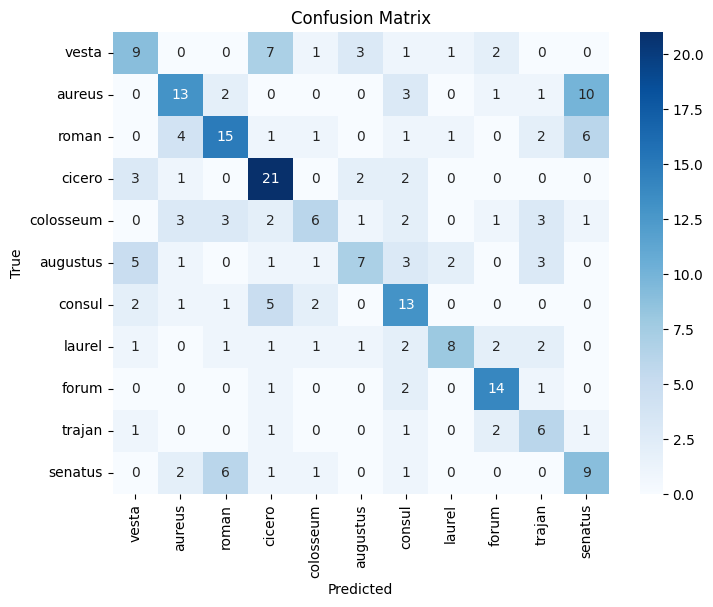

In [14]:
# *Insert Confusion Matrix here* for the Test Set
font_classes = ["vesta", "aureus", "roman", "cicero", "colosseum", "augustus", "consul", "laurel", "forum", "trajan", "senatus"] # Replace with actual font class names
plot_confusion_matrix(all_test_labels, all_test_predictions, classes=font_classes)

Define the output directory for saving model performance charts and create it if it doesn't already exist.
Plot and save training loss and accuracy per epoch, followed by precision, recall, and F1-score plots for both training and test sets to visualize model performance trends throughout training.


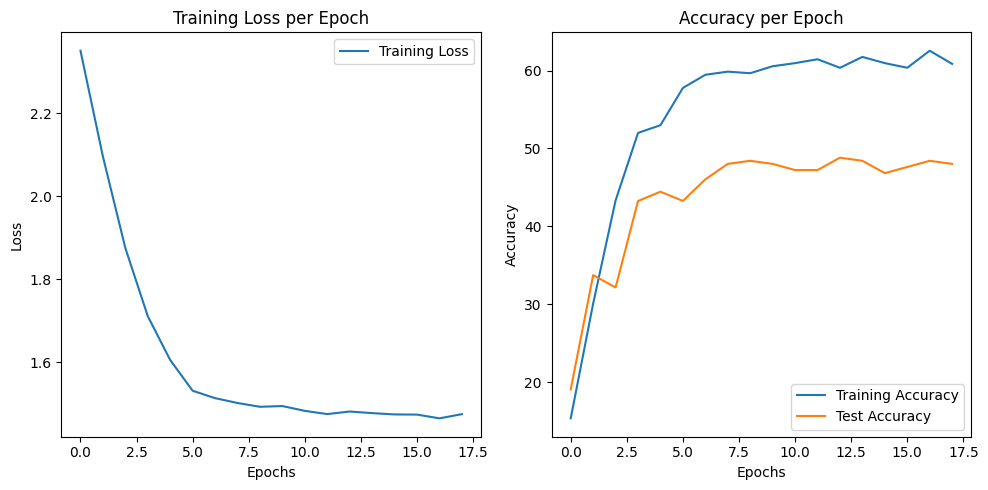

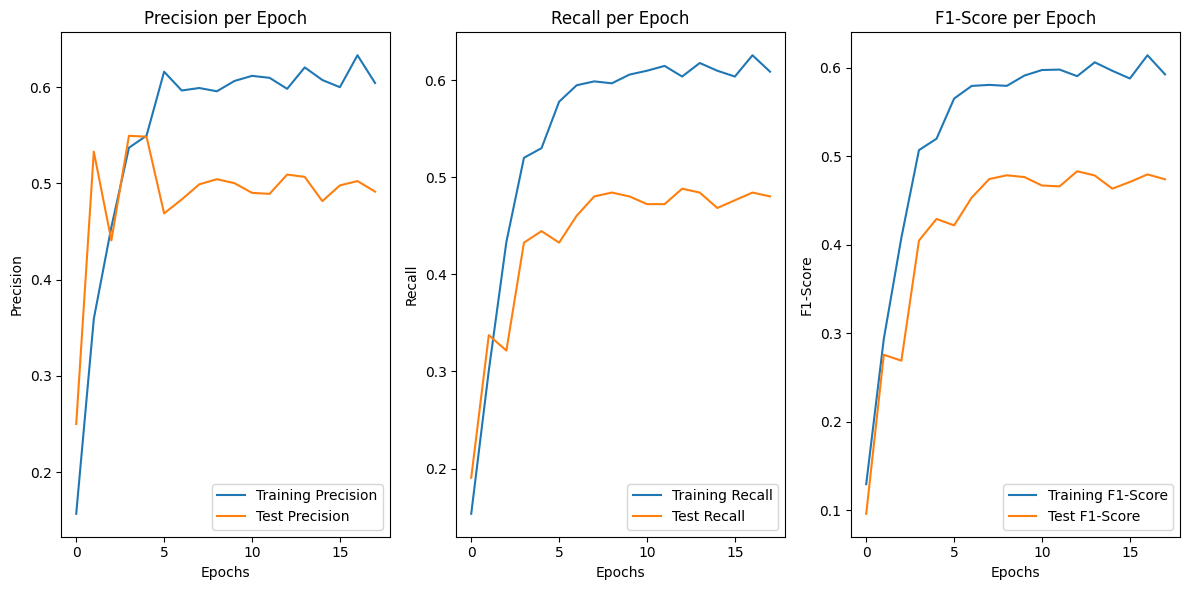

In [8]:

# Define the path for the 'model_charts' folder
model_result_path = f'{current_path}\\model_results'

# Create the folder if it doesn't exist
if not os.path.exists(model_result_path):
    os.makedirs(model_result_path)

# Plot and save the graphs for loss and accuracy
plt.figure(figsize=(10, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Save the figure to the 'model_charts' directory
plt.tight_layout()
plt.savefig(os.path.join(model_result_path, f'training_and_accuracy_charts_{epoch+1}.png'))
# Show the plot
plt.show()

# Plot Precision, Recall, F1-Score for each epoch
plt.figure(figsize=(12, 6))

# Precision plot
plt.subplot(1, 3, 1)
plt.plot(train_precisions, label='Training Precision')
plt.plot(test_precisions, label='Test Precision')
plt.title('Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(1, 3, 2)
plt.plot(train_recalls, label='Training Recall')
plt.plot(test_recalls, label='Test Recall')
plt.title('Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# F1-Score plot
plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Training F1-Score')
plt.plot(test_f1s, label='Test F1-Score')
plt.title('F1-Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

# Save the figure to the 'model_charts' directory
plt.tight_layout()
plt.savefig(os.path.join(model_result_path, f'precision_recall_f1_charts_{epoch+1}.png'))
# Show the plot
plt.show()


Organize the recorded training and test metrics into a dictionary for each epoch, convert it into a DataFrame, and save the results to an Excel file for later analysis.
Optionally, a CSV export is also available for compatibility with other tools.


In [ ]:
results = {
    'Epoch': list(range(1, len(train_losses) + 1)),
    'Training Loss': train_losses,
    'Training Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Training Precision': train_precisions,
    'Training Recall': train_recalls,
    'Training F1-Score': train_f1s,
    'Test Precision': test_precisions,
    'Test Recall': test_recalls,
    'Test F1-Score': test_f1s,
}

df_results = pd.DataFrame(results)
df_results.to_excel(f'{model_result_path}\\training_results_{epoch+1}.xlsx', index=False)
print("Results saved in 'training_results.xlsx'")


Results saved in 'training_results.xlsx'


Define the directory and file path to save the trained model, create the directory if it doesn't exist, and save the model's state dictionary to a .pth file for future loading and inference.


In [ ]:
model_dir = 'models_trained'
model_save_path = os.path.join(model_dir, f'trained_model_{epoch+1}_{batch_size}.pth')

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(model.state_dict(), model_save_path)
print(f"Modello salvato in {model_save_path}")

Modello salvato in models_trained\trained_model_18_36.pth
